# Fake News Classifier Final Report

Names:

Date:

# Introduction

- What is our project?
- What is the relevance?
- What is the data?
- What are our methods?

# Importing Necessary Libraries

In [4]:
# libraries for loading, preprocessing, visualization
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# libraries for NLTK
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import treebank
from nltk.stem import PorterStemmer

# libraries for spaCy
import spacy
from spacy import displacy


# libraries for Gensim
#import gensim
#from gensim.corpora import Dictionary

# libraries for ML models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report

# libraries for SHAP + LIME
#import shap
#shap.initjs()
import lime
from lime.lime_text import LimeTextExplainer


In [10]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_trf')

C:\Users\esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [11]:
# combining the two separate csv files with fake and real data to a single dataframe 
# import dataset
file_path = input("Enter the path of the csv file:")
df = pd.read_csv(file_path)

In [12]:
df.head()

,title,text,subject,date,type
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


# Exploratory Data Analysis

- look at missing values
- look at size
- look at data type
- look at distribution of type
- add Mahbuba's visualizations

- WHAT DID WE LEARN FROM EDA?

# Text Cleaning and Preprocessing

- drop na
- lower case
- remove stop words
- may need to create a smaller dataset

In [ ]:
# Tokenize and removing stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # remove non-alphabetical characters and stopwords
    cleaned_tokens = [re.sub(r'[^a-zA-Z ]', '', text).lower() for text in tokens if text.lower() not in stop_words]
    cleaned_tokens = [token for token in cleaned_tokens if ((token not in  set(string.punctuation)))]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in cleaned_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    #stem the tokens
    porter = PorterStemmer()
    cleaned_text = " ".join(porter.stem(token) for token in processed_text.split())
    return cleaned_text

# Apply the function across the DataFrame
df['cleaned_text'] = df['text'].apply(clean_text)

In [109]:
### CREATING A SMALLER DATASET TO TEST STUFF ###
# Separate the DataFrame into two subsets based on categories
true_df = df[df['type'] == 'True']
fake_df = df[df['type'] == 'Fake']

# Randomly sample an equal number of rows from each subset
sampled_true = true_df.sample(n=200, replace=False, random_state=42)
sampled_fake = fake_df.sample(n=200, replace=False, random_state=42)

# Combine the sampled rows into a single DataFrame
sampled_df = pd.concat([sampled_true, sampled_fake])

# Reset the index of the sampled DataFrame
sampled_df.reset_index(drop=True, inplace=True)

In [110]:
# remove stopwords
def remove_stopwords(doc):
    return ' '.join([token.text for token in nlp(doc) if not token.is_stop])

sampled_df['text'] = sampled_df['text'].apply(remove_stopwords)

In [111]:
# make all words lowercase
sampled_df['text'] = sampled_df['text'].str.lower()
sampled_df.head()

,title,text,subject,date,type
0,Europe rights watchdog says Turkey's emergency...,brussels ( reuters ) - leading european rights...,worldnews,"October 6, 2017",True
1,Exclusive: Trump targets illegal immigrants wh...,"( reuters ) - september 2014 , gilberto velasq...",politicsNews,"June 9, 2017",True
2,"At G20 summit, Trump pledges $639 million in a...",hamburg ( reuters ) - u.s. president donald tr...,politicsNews,"July 8, 2017",True
3,Ex-Christie associates lose bid for new trial ...,new york ( reuters ) - federal judge rejected ...,politicsNews,"March 2, 2017",True
4,Young blacks more open to Bernie Sanders' Whit...,"orangeburg , s.c. ( reuters ) - democratic hop...",politicsNews,"February 12, 2016",True


# Natural Language Processing

- Why do we do nlp? what are the benefits? why do we need it to build out fake news classifier?

## NLTK

- mention that it is our baseline
- pros and cons?
- what it does, how it works, what are some of its features?

## spaCy

tokenize, lemmatize, POS tagging, entity recognition

### spaCy Tokenizing

In [ ]:
df['spacy_tokens'] = df['text'].apply(lambda x: [token.text for token in nlp(x)])

In [ ]:
df.head()

### spaCy Lemmatizing

In [ ]:
# lemmatize the text (takes much longer to run than nltk)

df['lemms'] = df['text'].apply(lambda text: [token.lemma_ for token in nlp(text)])

In [ ]:
sampled_df.head()

### spaCy Part of Speech Tagging

In [21]:
# do pos tagging and convert it into a dictionary
sampled_df['pos_tag_dict'] = sampled_df['text'].apply(lambda text: {token.text: token.pos_ for token in nlp(text)})

Get the top 5 most common words for each part of speech to use in visualization.

In [105]:
# create a FAKE df for visualization
# select fake text
fake_pos = sampled_df[sampled_df['type'] == 'Fake']['pos_tag_dict']

# Extract POS and word into separate lists
f_pos_list = []
f_word_list = []

for pos_word in fake_pos:
    for pos, word in pos_word.items():
        f_pos_list.append(pos)
        f_word_list.append(word)

# Create DataFrame from lists
fakedf = pd.DataFrame({'Word': f_pos_list, 'POS': f_word_list})

# create mask to remove unwanted parts of speech
mask = ~fakedf['POS'].isin(['X', 'SPACE', 'PUNCT', 'SYM', 'AUX', 'CCONJ', 'PART', 'PRON'])
fakefiltdf = fakedf[mask]

# Group by POS and count occurrences of each word
pos_word_counts = fakefiltdf.groupby(['POS', 'Word']).size().reset_index(name='Count')

# Get top five most common words for each POS tag
faketop = pos_word_counts.groupby('POS').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')

print(faketop)

      POS          Word  Count
0     ADJ     political      6
1     ADJ           big      5
2     ADJ          high      5
3     ADJ        little      5
4     ADJ  presidential      5
5     ADP          like      5
6     ADP          away      2
7     ADP          amid      1
8     ADP        inside      1
9     ADP       outside      1
10    ADV             t     11
11    ADV      actually      4
12    ADV       clearly      4
13    ADV          long      4
14    ADV    absolutely      3
16   INTJ            ok      2
17   INTJ          f*ck      1
18   INTJ      freaking      1
19   INTJ            hi      1
20   NOUN        people     10
21   NOUN       country      8
22   NOUN         image      8
23   NOUN      campaign      6
24   NOUN    government      6
25    NUM          2017      3
26    NUM          1982      2
27    NUM          1985      2
28    NUM          1993      2
29    NUM          2002      2
30  PROPN         trump     14
31  PROPN        donald     11
32  PROP

C:\Users\esthe\AppData\Local\Temp\ipykernel_39400\4288116148.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  faketop = pos_word_counts.groupby('POS').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')


In [106]:
# create a TRUE df for visualization
# select true text
true_pos = sampled_df[sampled_df['type'] == 'True']['pos_tag_dict']

# Extract POS and word into separate lists
t_pos_list = []
t_word_list = []

for pos_word in true_pos:
    for pos, word in pos_word.items():
        t_pos_list.append(pos)
        t_word_list.append(word)

# Create DataFrame from lists
truedf = pd.DataFrame({'Word': t_pos_list, 'POS': t_word_list})

# create mask to remove unwanted parts of speech
mask = ~truedf['POS'].isin(['X', 'SPACE', 'PUNCT', 'SYM', 'AUX', 'CCONJ', 'PART', 'PRON'])
truefiltdf = truedf[mask]

# Group by POS and count occurrences of each word
t_pos_word_counts = truefiltdf.groupby(['POS', 'Word']).size().reset_index(name='Count')

# Get top five most common words for each POS tag
truetop = t_pos_word_counts.groupby('POS').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True). drop_duplicates('Word')

print(truetop)

      POS            Word  Count
0     ADJ             new      6
1     ADJ    presidential      6
2     ADJ          public      6
3     ADJ      republican      6
4     ADJ           legal      5
5     ADP            like      4
6     ADP         outside      2
7     ADP            amid      1
8     ADP            away      1
9     ADP          inside      1
10    ADV     immediately      4
11    ADV      previously      3
12    ADV               t      3
13    ADV      absolutely      2
14    ADV           ahead      2
15   NOUN            year     10
16   NOUN      government      9
17   NOUN          people      7
18   NOUN  administration      6
19   NOUN        campaign      6
20    NUM         million      4
21    NUM              20      3
22    NUM            2012      3
23    NUM              30      3
24    NUM              90      3
25  PROPN         reuters     20
26  PROPN       president     14
27  PROPN             u.s     12
28  PROPN          donald     11
29  PROPN 

C:\Users\esthe\AppData\Local\Temp\ipykernel_39400\1559870938.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truetop = t_pos_word_counts.groupby('POS').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True). drop_duplicates('Word')


In [107]:
# Get Seaborn's default color palette
palette = sns.color_palette()

# Create the dictionary with default Seaborn colors
pos_colors = {
    'ADJ': palette[0],
    'ADP': palette[1],
    'ADV': palette[2],
    'INTJ': palette[3],
    'NOUN': palette[4],
    'NUM': palette[5],
    'PROPN': palette[9],
    'SCONJ': palette[8],
    'VERB': palette[6]
}

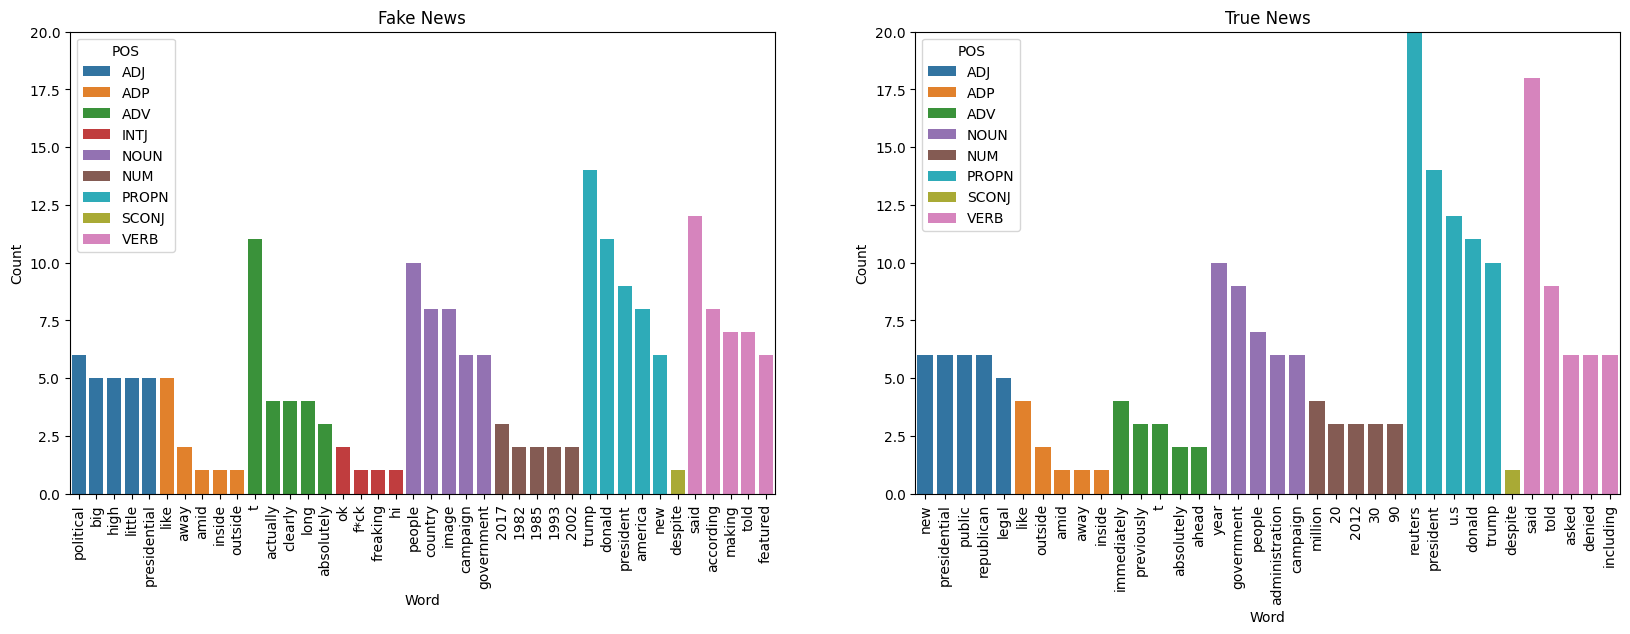

In [108]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot the first barplot on the first subplot
sns.barplot(data=faketop, x='Word', y='Count', hue='POS', ax=axs[0], linewidth=2, palette = pos_colors)
axs[0].set_title('Fake News')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Word')
axs[0].tick_params(axis='x', rotation=90)

# Plot the second barplot on the second subplot
sns.barplot(data=truetop, x='Word', y='Count', hue='POS', ax=axs[1], linewidth=2, palette = pos_colors)
axs[1].set_title('True News')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Word')
axs[1].tick_params(axis='x', rotation=90)

# Set y-axis limits to ensure the same scale
max_count = max(faketop['Count'].max(), truetop['Count'].max())
for ax in axs:
    ax.set_ylim(0, max_count)

# Show the plot
plt.show()

### spaCy Entity Recognition

spaCy's statistical entity recognition system assigns labels to contigouos spans of tokens. It works to identify a variety of named numeric entities including companies, locations, organizations, and products. In the context of our project, this is valuable as it will allow us to identify if there are any particular entities that are more prominent in fake news or real news.

- GPE: Geo-Political Entity. It refers to countries, cities, states, and other named places.
- DATE: Refers to specific dates or periods mentioned in the text.
- PERSON: Individual people, including fictional and real names.
- NORP: Nationalities or religious or political groups.
- FAC: Buildings, airports, highways, bridges, etc.
- ORG: Companies, agencies, institutions, etc.
- GPE: Countries, cities, states.
- LOC: Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT: Objects, vehicles, foods, etc. (Not services.)
- EVENT: Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART: Titles of books, songs, etc.
- LAW: Named documents made into laws.
- LANGUAGE: Any named language.

In [114]:
sampled_df['Entities_Dict'] = sampled_df['text'].apply(lambda text: {token.text: token.ent_type_ for token in nlp(text)})

sampled_df['Entities_Dict'].head()

0    {'brussels': 'GPE', '(': '', 'reuters': 'ORG',...
1    {'(': '', 'reuters': 'ORG', ')': '', '-': '', ...
2    {'hamburg': 'GPE', '(': '', 'reuters': 'ORG', ...
3    {'new': 'GPE', 'york': 'GPE', '(': '', 'reuter...
4    {'orangeburg': '', ',': '', 's.c': 'GPE', '.':...
Name: Entities_Dict, dtype: object

In [115]:
# Remove blank values in the dictionaries
for index, entity_dict in enumerate(sampled_df['Entities_Dict']):
    # Remove key-value pairs where the value is an empty string
    cleaned_entity_dict = {k: v for k, v in entity_dict.items() if v != ''}
    # Update the 'Entities_Dict' column with the cleaned dictionary
    sampled_df.at[index, 'Entities_Dict'] = cleaned_entity_dict

# Print the updated 'Entities_Dict' column
print(sampled_df['Entities_Dict'].head())

0    {'brussels': 'GPE', 'reuters': 'ORG', 'europea...
1    {'reuters': 'ORG', 'september': 'DATE', '2014'...
2    {'hamburg': 'GPE', 'reuters': 'ORG', 'u.s': 'G...
3    {'new': 'GPE', 'york': 'GPE', 'reuters': 'ORG'...
4    {'s.c': 'GPE', 'reuters': 'ORG', '-': 'DATE', ...
Name: Entities_Dict, dtype: object


In [116]:
# remove keys with no assigned entity values
def rmv_empty_ents(df):
    for _, row in df.iterrows():
        entities_copy = row['Entities_Dict'].copy()  # Create a copy of the dictionary
        for k, v in entities_copy.items():  # Iterate over the copy
            if v == '':
                del row['Entities_Dict'][k]  # Modify the original dictionary
    return df

sampled_df = rmv_empty_ents(sampled_df)
sampled_df['Entities_Dict'].head()

0    {'brussels': 'GPE', 'reuters': 'ORG', 'europea...
1    {'reuters': 'ORG', 'september': 'DATE', '2014'...
2    {'hamburg': 'GPE', 'reuters': 'ORG', 'u.s': 'G...
3    {'new': 'GPE', 'york': 'GPE', 'reuters': 'ORG'...
4    {'s.c': 'GPE', 'reuters': 'ORG', '-': 'DATE', ...
Name: Entities_Dict, dtype: object

Create a fake and true entity dfs for plotting.

In [121]:
# create a TRUE df for visualization
# select true text
true_ent = sampled_df[sampled_df['type'] == 'True']['Entities_Dict']

# Extract POS and word into separate lists
t_ent_list = []
t_word_list = []

for ent_word in true_ent:
    for word, ent in ent_word.items():  # Change 'pos' to 'ent'
        t_ent_list.append(ent)  # Change 'pos_list' to 'ent_list'
        t_word_list.append(word)

# Create DataFrame from lists
truedf = pd.DataFrame({'Ent': t_ent_list, 'Word': t_word_list})  # Swap 'Ent' and 'Word'

# create mask to remove unwanted parts of speech
mask = ~truedf['Ent'].isin(['CARDINAL', 'ORDINAL', 'PERCENT', 'WORK_OF_ART','MONEY', 'DATE', 'QUANTITY'])
truefiltdf = truedf[mask]

# Group by POS and count occurrences of each word
t_ent_word_counts = truefiltdf.groupby(['Ent', 'Word']).size().reset_index(name='Count')  # Change 'POS' to 'Ent'

# Get top five most common words for each POS tag
ent_truetop = t_ent_word_counts.groupby('Ent').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')

print(ent_truetop)

        Ent           Word  Count
0     EVENT            war      4
1     EVENT     convention      3
2     EVENT      hurricane      2
3     EVENT       national      2
4     EVENT     republican      2
5       FAC        airport      4
6       FAC           base      2
7       FAC         border      2
8       FAC        capital      2
9       FAC        capitol      2
10      GPE            u.s     96
11      GPE     washington     70
12      GPE         united     51
13      GPE         states     49
14      GPE            new     29
15      LAW            act      7
16      LAW      obamacare      7
17      LAW   constitution      3
18      LAW  authorization      2
19      LAW        defense      2
20      LOC         europe      9
21      LOC           east      7
22      LOC         middle      7
23      LOC           asia      5
24      LOC       southern      5
26     NORP     democratic     29
27     NORP    republicans     27
28     NORP      democrats     26
29     NORP   

C:\Users\esthe\AppData\Local\Temp\ipykernel_39400\1059305310.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent_truetop = t_ent_word_counts.groupby('Ent').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')


In [122]:
# create a fake df for visualization
# select fake text
fake_ent = sampled_df[sampled_df['type'] == 'Fake']['Entities_Dict']

# Extract POS and word into separate lists
f_ent_list = []
f_word_list = []

for ent_word in fake_ent:
    for word, ent in ent_word.items():  # Change 'pos' to 'ent'
        f_ent_list.append(ent)  # Change 'f_pos_list' to 'f_ent_list'
        f_word_list.append(word)

# Create DataFrame from lists
fakedf = pd.DataFrame({'Ent': f_ent_list, 'Word': f_word_list})

# create mask to remove unwanted parts of speech
mask = ~fakedf['Ent'].isin(['CARDINAL', 'ORDINAL', 'PERCENT', 'WORK_OF_ART', 'MONEY', 'DATE', 'QUANTITY'])
fakefiltdf = fakedf[mask]

# Group by POS and count occurrences of each word
f_ent_word_counts = fakefiltdf.groupby(['Ent', 'Word']).size().reset_index(name='Count')  # Change 'f_pos_word_counts' to 'f_ent_word_counts'

# Get top five most common words for each POS tag
ent_faketop = f_ent_word_counts.groupby('Ent').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')

print(ent_faketop)

        Ent          Word  Count
0     EVENT           war      4
1     EVENT           new      3
2     EVENT           day      2
3     EVENT         games      2
4     EVENT         world      2
5       FAC        avenue      2
6       FAC     boulevard      2
7       FAC         hills      2
8       FAC             -      1
9       FAC             1      1
10      GPE        states     36
11      GPE        united     34
12      GPE       america     28
13      GPE           u.s     25
14      GPE        russia     18
15      LAW           act      5
16      LAW     amendment      3
17      LAW  constitution      2
18      LAW     obamacare      2
19      LAW          10th      1
20      LOC          east      5
21      LOC        europe      5
22      LOC        middle      5
23      LOC      southern      3
24      LOC        africa      2
25     NORP      american     39
26     NORP     americans     37
27     NORP   republicans     35
28     NORP    republican     34
29     NOR

C:\Users\esthe\AppData\Local\Temp\ipykernel_39400\109183580.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent_faketop = f_ent_word_counts.groupby('Ent').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True).drop_duplicates('Word')


Visualize the results with a Bar Plot.

In [123]:
# Get Seaborn's default color palette
palette = sns.color_palette()

# Create the dictionary with default Seaborn colors
ent_colors = {
    'PERSON': palette[0],
    'EVENT': palette[1],
    'FAC': palette[2],
    'GPE': palette[3],
    'LAW': palette[4],
    'LOC': palette[5],
    'NORP': palette[6],
    'ORG': palette[9],
    'PRODUCT': palette[8],
    'TIME': palette[7]
}



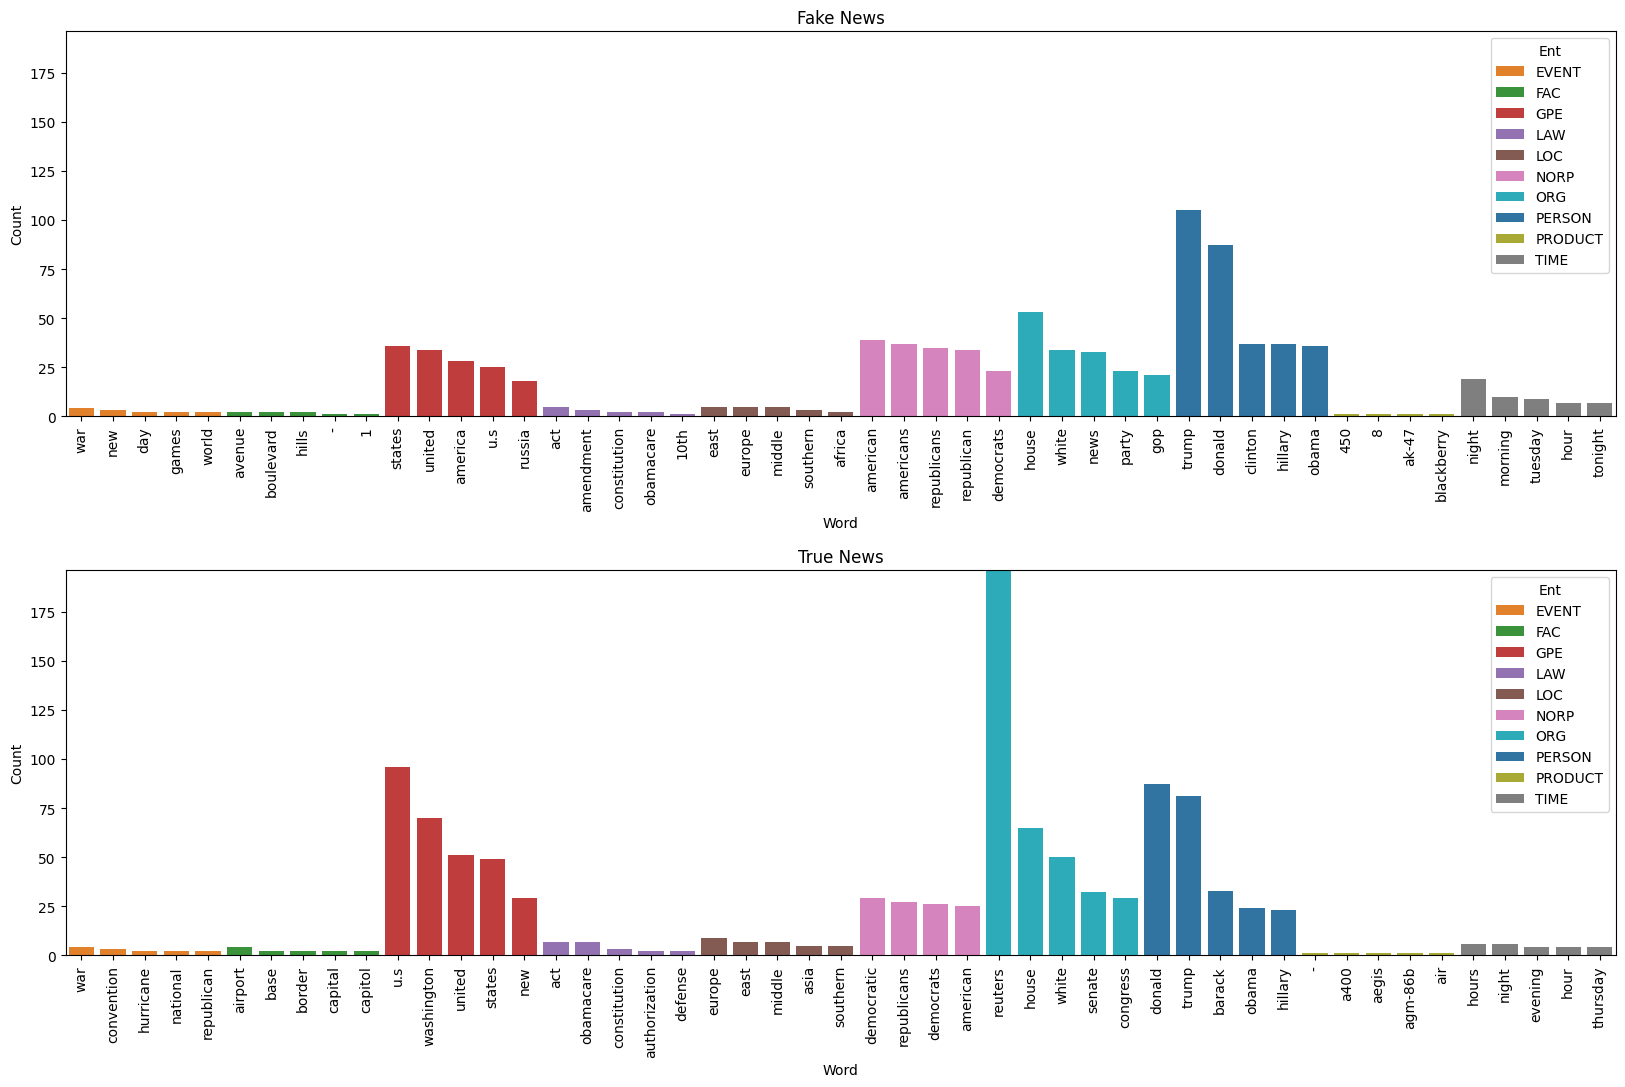

In [124]:
import matplotlib.ticker as ticker

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 12))  # Change 1 to 2 for two subplots vertically

# Plot the first barplot on the first subplot
sns.barplot(data=ent_faketop, x='Word', y='Count', hue='Ent', ax=axs[0], linewidth=8, palette=ent_colors)
axs[0].set_title('Fake News')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Word')
axs[0].tick_params(axis='x', rotation=90)

# Plot the second barplot on the second subplot
sns.barplot(data=ent_truetop, x='Word', y='Count', hue='Ent', ax=axs[1], linewidth=8, palette=ent_colors)
axs[1].set_title('True News')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Word')
axs[1].tick_params(axis='x', rotation=90)

# Set y-axis labels to integers
for ax in axs:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))

# Set y-axis limits to ensure the same scale
max_count = max(ent_faketop['Count'].max(), ent_truetop['Count'].max())
for ax in axs:
    ax.set_ylim(0, max_count)

# Adjust space between subplots
plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()




## Gensim

### Topic Modeling

Topic Modeling is useful for...

Here we will be using the Latent Dirichlet Allocation (LDA), which is the most popular technique for topic modeling.

It works by...

https://medium.com/nlplanet/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06#3363

In [125]:
!pip install pyLDAvis

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.6 MB 6.4 MB/s eta 0:00:01
   ----- ---------------------------------- 0.4/2.6 MB 4.5 MB/s eta 0:00:01
   --------- ------------------------------ 0.6/2.6 MB 4.8 MB/s eta 0:00:01
   ------------- -------------------------- 0.9/2.6 MB 5.1 MB/s eta 0:00:01
   -------------------- ------------------- 1.3/2.6 MB 6.1 MB/s eta 0:00:01
   ----------------------------- ---------- 1.9/2.6 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------  2.6/2.6 MB 8.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 7.9 MB/s eta 0:00:00


In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [ ]:
# split dataset into fake and real
fakedf = sampled_df[sampled_df['type'] == 'Fake']
truedf = sampled_df[sampled_df['type'] == 'True']

fake_doc = [fakedf['text']]
true_doc = [truedf['text']]

# create a dictionary and a corpus
true_dict = corpora.Dictionary(true_doc)
fake_dict = corpora.Dictionary(fake_doc)

true_corp = [true_dict.doc2bow(doc) for doc in documents]
fake_corp = [fake_dict.doc2bow(doc) for doc in documents]

# train the LDA model
true_lda = LdaModel(true_corp, num_topics = 5, id2word = true_dict)
fake_lda = LdaModel(fake_corp, num_topics = 5, id2word = fake_dict)

# visualize the topics
true_lda_viz = gensimvis.prepare(true_lda, true_corp, true_dict)
pyLDAvis.display(true_lda_viz)

fake_lda_viz = gensimvis.prepare(fake_lda, fake_corp, fake_dict)
pyLDAvis.display(fake_lda_viz)

# Building Classification Models

- decision tree
- knn
- XGBoost
- 

### Decision Tree Classifier

In [ ]:
# defining X and y arrays
# X = word_vectors
X = df['cleaned_text'].values
y = df['target'].values

In [ ]:
# Create training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

In [ ]:
# defining the Tfidf vectorizer
vectorizer = TfidfVectorizer(min_df=10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

In [ ]:
# defining the classification model
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(X_train_vec,y_train)

DecisionTreeClassifier()

In [ ]:
# predicting the test values
y_pred = tree_clf.predict(X_test_vec)
# printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7649
           1       1.00      0.99      0.99      7168

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817



# Evaluating Model Performance

- what metrics are we using to evaluate models? how do they work? how are they different? why did we pick that particular evaluation metric?

- ALSO SHOW WHAT EXACTLY WAS MISCLASSIFIED, AND PLOT IT?

- ADD PLOTS COMPARING THE PERFORMANCE OF EACH MODEL

# Model Explainability

- why is model explainability important?



## Using Decision Tree classifier features

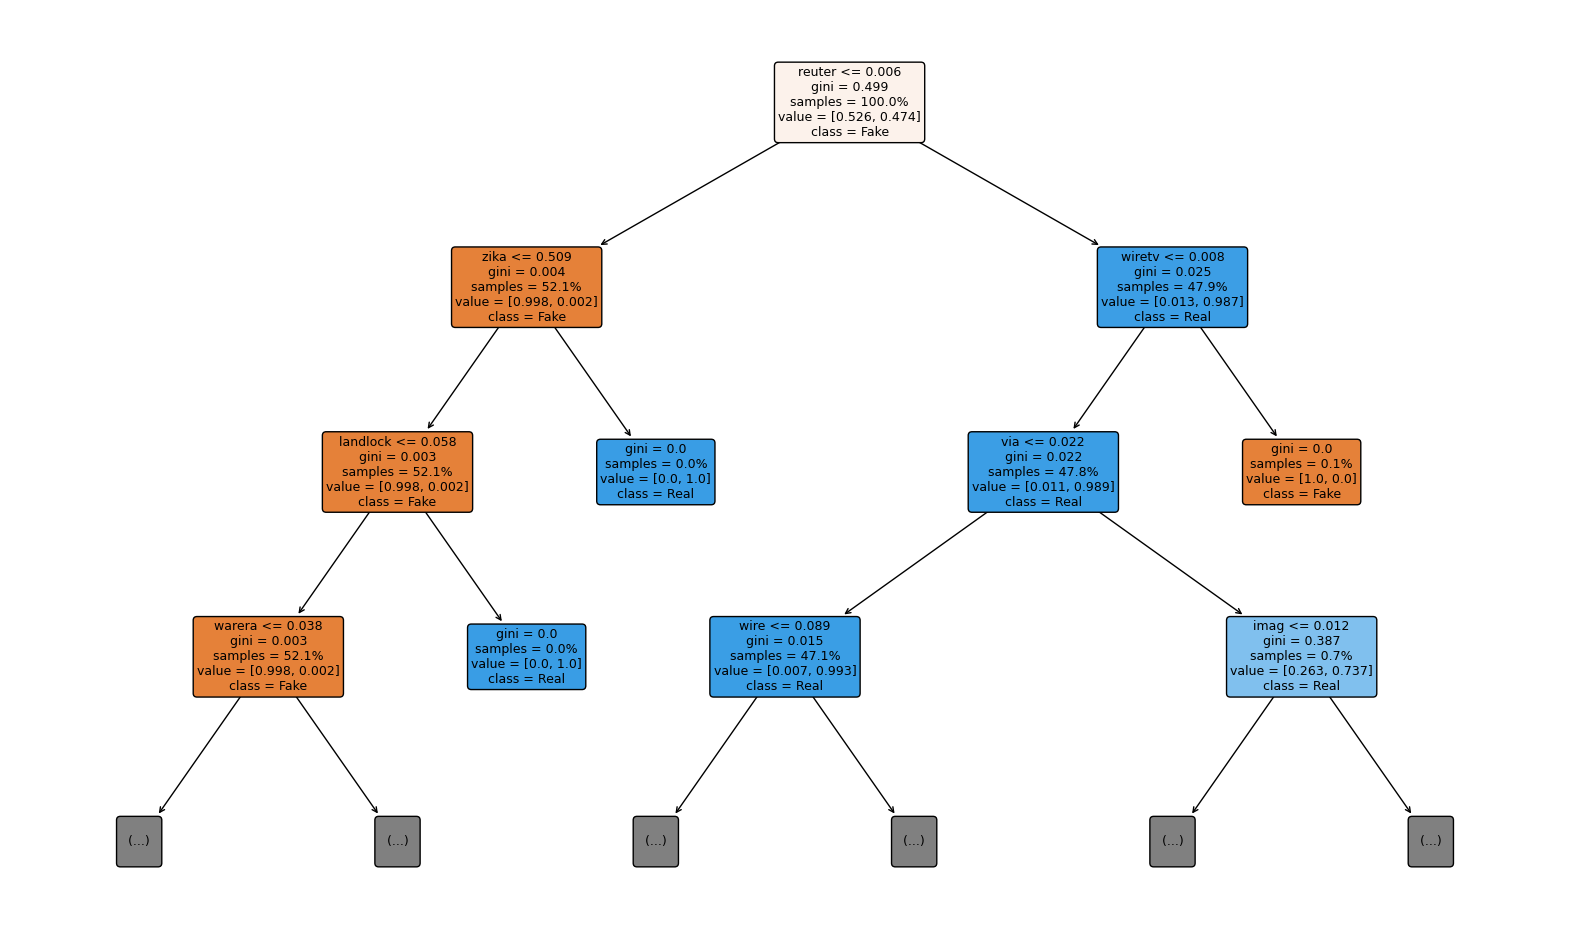

In [ ]:
class_names = ["Fake", "Real"]

fig = plt.figure(figsize=(20, 12))
vis = tree.plot_tree(
    tree_clf,
    class_names=class_names,
    feature_names = vectorizer.get_feature_names_out(),
    max_depth=3,
    fontsize=9,
    proportion=True,
    filled=True,
    rounded=True
)
plt.show()

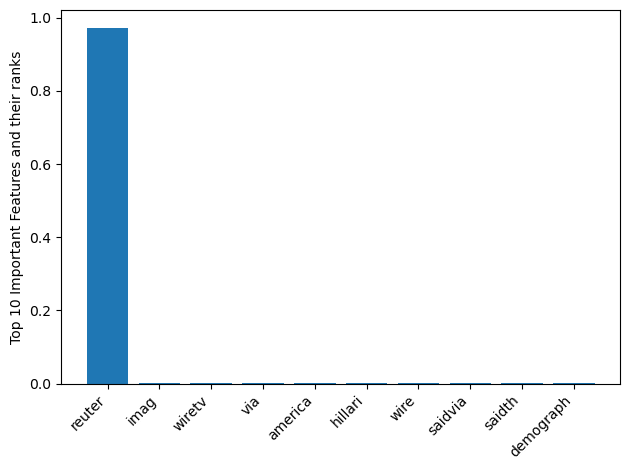

In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_importance = tree_clf.feature_importances_
inds = np.argsort(np.abs(feature_importance))[::-1]
top_10_inds = inds[:10]
fig, ax = plt.subplots()
rank = np.arange(10)
ax.bar(rank, feature_importance[top_10_inds])
ax.set_xticks(rank)
ax.set_xticklabels(np.array(feature_names)[top_10_inds], rotation=45, ha='right')
ax.set_ylabel("Top 10 Important Features and their ranks")
plt.tight_layout()
plt.show()

- what is it, how does it work?

The above tree visualization of the classifier indicates that the classifier uses 'reuter' feature as one of the main feature to decide whether the text is fake or real. In the next level, 'zika' and 'wiretv' are used to split the data into the respective classes based on certain threshold values for the features. The bar chart on the feature importance also indicates that the 'reuter' feature have a huge significance in influencing the model decision compared to other features. 


## SHAP

- what is it, how does it work?

In [ ]:
# getting the feature names from tfidf vectorizer
feature_names = vectorizer.get_feature_names_out()
# getting the shap values
explainer = shap.Explainer(tree_clf, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)
print(shap_values.values.shape)

 99%|===================| 29343/29634 [00:52<00:00]        

(14817, 16341, 2)


harrisburg pa reuter u presid donald trump hit road saturday celebr first day white hous cheer support campaignstyl ralli tout initi achiev lash critic trump told pennsylvania crowd get start meet campaign promis repeatedli attack incompet dishonest medium say tell truth administr accomplish administr deliv everi singl day great citizen countri trump said harrisburg pennsylvania keep one promis anoth frankli peopl realli happi it ralli occur day climat march thousand protest surround white hous also coincid annual blackti white hous press dinner washington trump staff chose skip press dinner said unfair treatment press trump said thrill away washington swamp larg group hollywood actor washington medium consol hotel ballroom nation capit right trump said loud boo crowd medium job honest tell truth medium deserv big fat fail grade trump list said key earli accomplish includ success confirm u suprem court justic neil gorsuch clear away mani regul environ busi also list approv keyston xl d

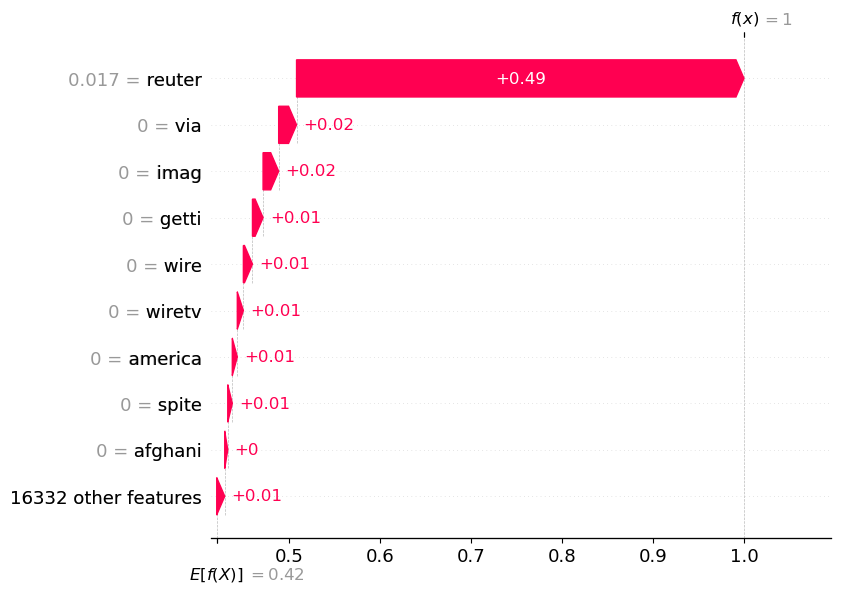

In [ ]:
# getting the shap waterfall plot for the 7th test data
shap.initjs()

ind = 6
print(X_test[ind])

shap.plots.waterfall(shap_values[ind,:,1])

madonna took instagram late thursday promot upcom antidonald trump protest march share photo woman shoe compani nike logo appar shave public hair yasssssssss nakidmagazin madonna wrote ad million woman march washington dc jan yasssssssss nakidmagazin million woman s march washington dc jan photo mariu sperlicha post share madonna madonna jan pm psta breitbart news previous report thousand woman expect travel nation capit woman march washington protest presidentelect donald trump inaugurationth organ said want event send bold messag new administr first day offic world woman right human right earlier week singer kati perri cher actress scarlett johansson zendaya debra mess juliann moor announc expect particip januari eventth yearold rebel heart singer spent month slam trump campaign drum support hillari clinton octob madonna famous offer oral sex anyon vote former democrat nomineelast month madonna admit trump elect left devast entir stori breitbart


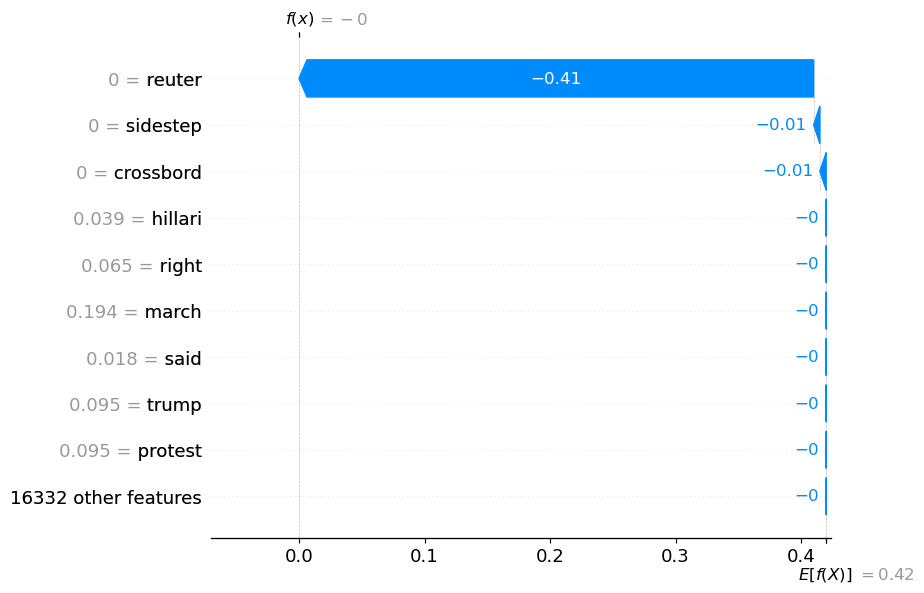

In [ ]:
# getting the shap waterfall plot for the 11th test data
shap.initjs()

ind = 10
print(X_test[ind])

shap.plots.waterfall(shap_values[ind,:,1])

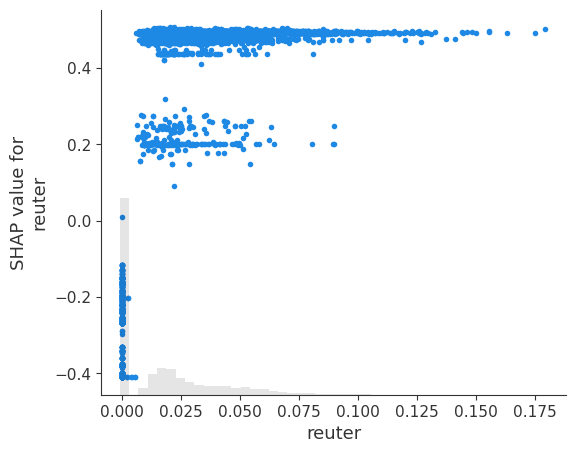

In [ ]:
shap.plots.scatter(shap_values[:,feature_names.tolist().index("reuter"),1])

The above plot shows how the 'reuter' feature influences the model in predicting an object as class 1 - real. Most of the shap values for this feature lies closer to 0.5 implying its importance for the classifier in predicting classes as real.

- What do the result show, or what do they mean?

  From the three waterfall plots above, it is clear that the model uses the word 'reuter' as the primary indicator of whether a text classifies as fake or real. If the shap value of 'reuter' is greater than 0, it classifies the text as real and vice versa.

## LIME

- what is it, how does it work?
- run lime multiple times and on a larger sample size

- What do the result show, or what do they mean?

# Conclusion

- Short overview of whole project: why? what? how?
- where the data was found, what is its structure
- how the data was pre-processed and cleaned
- language processing techniques and what they showed us, how are they different?
- models, how they performed, how are they unique
- model explainability, how did the model make decisions?
- model evaluation, what does it mean in the greater context?
- conclusion